In [39]:
import pandas
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import random
import matplotlib.pyplot as plt
import numpy as np

In [40]:
ACTIONS = ["charge", "discharge", "generator", "discharge + generator", "nothing"]
NB_ACTION = len(ACTIONS)
EPS = 5e-2
GAMMA = 1.0

class State:
    def __init__(self):
        self.battery = 0.0
        self.panelProd = 0.0
        self.consumption = 0.0
        self.price = 0.0
        self.daytime = 0.0
        self.row = 0
  
    def toArray(self):
        return np.array([self.battery, self.panelProd, self.consumption, self.price,0]) #self.daytime])

In [66]:
class Env:
    def __init__(self):
        # load data (csv)
        #importation données
        df = pandas.read_csv("select_data.csv", sep = ',', header = 0)
        
        self.data=df.values
        # for i in range(len(self.data)):
        #     self.data[i,3]=self.data[i,3]*8000
        # print(self.data[500])

        # Prétraitement des données
        # TODO: transformer daytime en float
        self.panelProdMax = max(self.data[:,5])
        self.consumptionMax = max(self.data[:,4])
        
        self.data[:,5] /= self.panelProdMax
        self.data[:,4] /= self.consumptionMax

        self.initState()
        self.batteryCapacity = 60000.0 / self.panelProdMax
        self.generatorCapacity = 20000.0 / (12 * self.panelProdMax) # Energie produite par le générateur en 5min

        self.co2Price = 25.0*0.001      #price per ton of CO2 (mean price from the european market)
        self.co2Generator = 8*0.001    #kg of CO2 generated per kWh from the diesel generator
        self.co2Market = 0.3204        #kg of CO2 generated per kWh from the national power market (danish)

        self.chargingCost = 0.0
        self.dischargingCost = 0.0
        #self.solarCost = 0.0
        self.generatorCost = 0.4      #0.314 à 0.528 $/kWh

        self.chargingYield = 1.0
        self.dischargingYield = 1.0


    def initState(self):
        self.currentState = State()
        self.currentState.row = np.random.randint(0, len(self.data)) # Deuxième valeur à modifier en fonction du nombre de steps réalisés par épisode
        row = self.currentState.row
        self.currentState.daytime = self.data[row,1]
        self.currentState.panelProd = self.data[row,3]
        self.currentState.price = self.data[row,4]
        self.currentState.consumption = self.data[row,5]

    def act(self, action):
        totalProd = self.currentState.panelProd
        diffProd = totalProd - self.currentState.consumption
        cost=0.0

        if action == "charge":
            if (diffProd>0):
                charge = min(diffProd,(self.batteryCapacity-self.currentState.battery)/self.chargingYield)
                self.currentState.battery+=charge*self.chargingYield
                diffProd-=charge
                cost+=charge*self.chargingCost


        elif action == "discharge":
            if (diffProd<0):
                discharge = max(diffProd/self.dischargingYield,-self.currentState.battery)
                self.currentState.battery+=discharge
                diffProd-=discharge*self.dischargingYield
                cost+=abs(discharge*self.dischargingCost)


        elif action == "generator":
              if (diffProd<0):
                generate=min(-diffProd, self.generatorCapacity)
                diffProd+=generate
                cost+=generate*self.generatorCost


        elif action == "discharge + generator":
            if (diffProd<0):
                discharge = max(diffProd/self.dischargingYield,-self.currentState.battery)
                self.currentState.battery+=discharge
                diffProd-=discharge*self.dischargingYield
                cost+=abs(discharge*self.dischargingCost)


            if (diffProd<0):
                generate=min(-diffProd, self.generatorCapacity)
                diffProd+=generate
                cost+=generate*self.generatorCost

        cost+=diffProd*self.currentState.price

        #UPDATE SELF.PANELPROD, PRICE, CONSUMPTION, DAYTIME according to the dataset
        row = self.currentState.row + 1
        self.currentState.daytime = self.data[row,1]
        self.currentState.panelProd = self.data[row,5]
        self.currentState.price = self.data[row,3]
        self.currentState.consumption = self.data[row,4]
        self.currentState.row = row

        return -cost, self.currentState


    def getState(self):
        return self.currentState


In [42]:
def DQN(n_neurons, input_size):
    model = tf.keras.Sequential(name="DQN")
    model.add(layers.Dense(n_neurons, input_shape=(input_size,), bias_initializer="glorot_normal", 
                           kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dense(n_neurons, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Dense(units = 1, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    return model

In [43]:
def predict(model, state, action):
    input_model = np.array([0.0]*NB_ACTION + list(state.toArray()))

    if action == "charge":
        input_model[0] = 1.0
    elif action == "discharge":
        input_model[1] = 1.0
    elif action == "generator":
        input_model[2] = 1.0
    elif action == "discharge + generator":
        input_model[3] = 1.0
    else:
        input_model[4] = 1.0

    #print(action)
    #print(input_model)
    res= model(np.array([input_model]))

    #print(input_model, res)
    return res

In [44]:
def policy(model, state):
    q_value = [predict(model, state, action) for action in ACTIONS]
    prob = np.ones(NB_ACTION) * EPS / NB_ACTION
    prob[np.argmax(q_value)] += 1.0 - EPS
    return prob

In [45]:
def loss(model, transitions_batch):
    y = []
    q = []
    for state, action, reward, next_state in transitions_batch:
        q_value = [predict(model, next_state, a) for a in ACTIONS]
        best_next_action = np.argmax(q_value)
        y.append(reward + GAMMA * q_value[best_next_action])
        q.append(predict(model, state, action))
    
    return tf.reduce_mean(tf.square(q - tf.stop_gradient(y)), name="loss_mse_train")

In [46]:
def train_step(model, transitions_batch):
    #batch_size = transitions_batch.shape[0]
    
    with tf.GradientTape() as disc_tape:
        disc_loss = loss(model, transitions_batch)

    gradients = disc_tape.gradient(disc_loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return disc_loss

Train

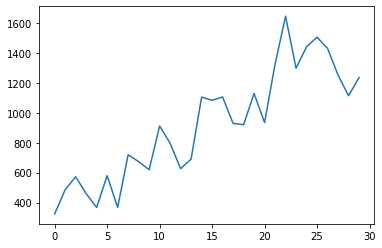

In [67]:
env = Env()
env.initState()

nb_episodes = 100
nb_steps = 10
batch_size = 10

DQN_model = DQN(n_neurons=10, input_size=10)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

state = env.currentState

replay_memory = []
replay_memory_init_size = 100

for i in range(replay_memory_init_size):
    action_probs = policy(DQN_model, state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    reward, next_state = env.act(action)
    replay_memory.append((state, action, reward, next_state))
    state=next_state

loss_hist = []

for i_episode in range(nb_episodes):
    env.initState()
    state = env.currentState
    loss_episode = 0.0
    #print(i_episode)

    for step in range(nb_steps):
        action_probs = policy(DQN_model, state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        reward, next_state = env.act(action)
        
        replay_memory.pop(0)
        replay_memory.append((state, action, reward, next_state))

        samples = random.sample(replay_memory, batch_size)

        loss_episode += train_step(DQN_model, samples)
        state=next_state
    
    loss_hist.append(loss_episode)

plt.plot(loss_hist)

Test

In [60]:
conso=[]
prod=[]
battery=[]
price=[]
actions=[]
cost=[]
env.initState()
print(env.currentState.daytime)
for i in range(300):
    action_probs = policy(DQN_model, state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    reward, next_state = env.act(action)
    replay_memory.append((state, action, reward, next_state))
    conso.append(state.consumption)
    prod.append(state.panelProd)
    battery.append(state.battery)
    price.append(state.price)
    cost.append(-reward)
    actions.append(action)
    state=next_state
    
    #if (i%100==0):
    #    print(i)

t = [i for i in range(300)]

2019-06-22 15:45:00+00:00


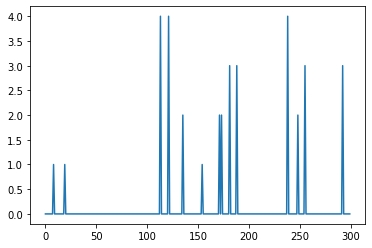

In [61]:
plt.plot(t, actions)

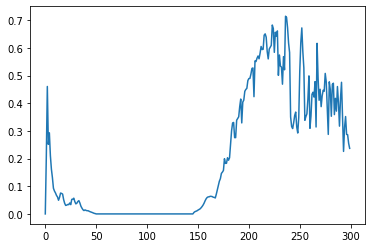

In [62]:
plt.plot(conso)

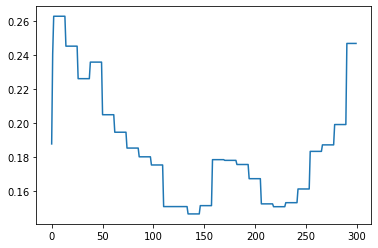

In [64]:
plt.plot(prod)

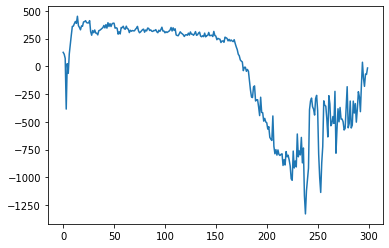

In [63]:
plt.plot(cost)

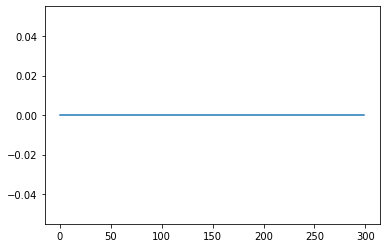

In [65]:
plt.plot